In [377]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import os
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!conda install -c statsmodels statsmodels=0.8

In [2]:
path=r"C:\Reports\FC"
data = pd.read_csv(os.path.join(path,'total_sales.csv'),';', index_col=['month'], parse_dates=['month'], dayfirst=True)

fulldata=data
data=data.ix[:-3]
data.tail(3)

,sales
month,
2016-10-01,7768538609
2016-11-01,8179133401
2016-12-01,12140414460


In [ ]:
#обратное преобразование Бокса Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

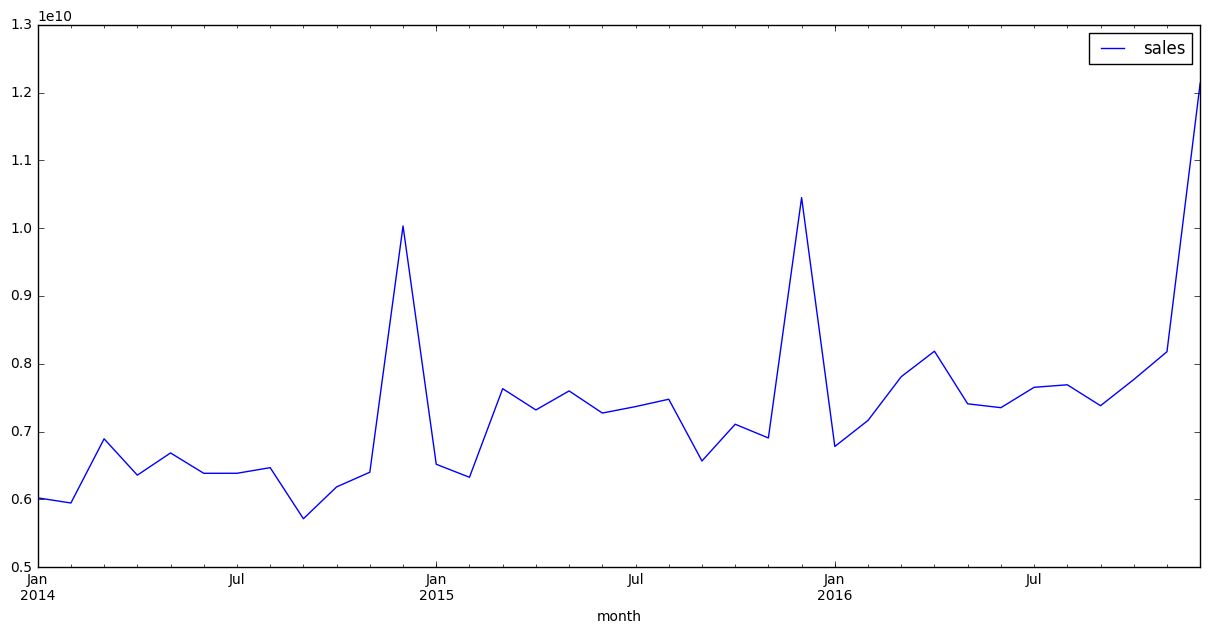

In [3]:
plt.figure(figsize(15,7))
data.plot()
#plt.ylabel(u'')
#plt.title('')
pylab.show()

Критерий Дики-Фуллера: p=0.009591


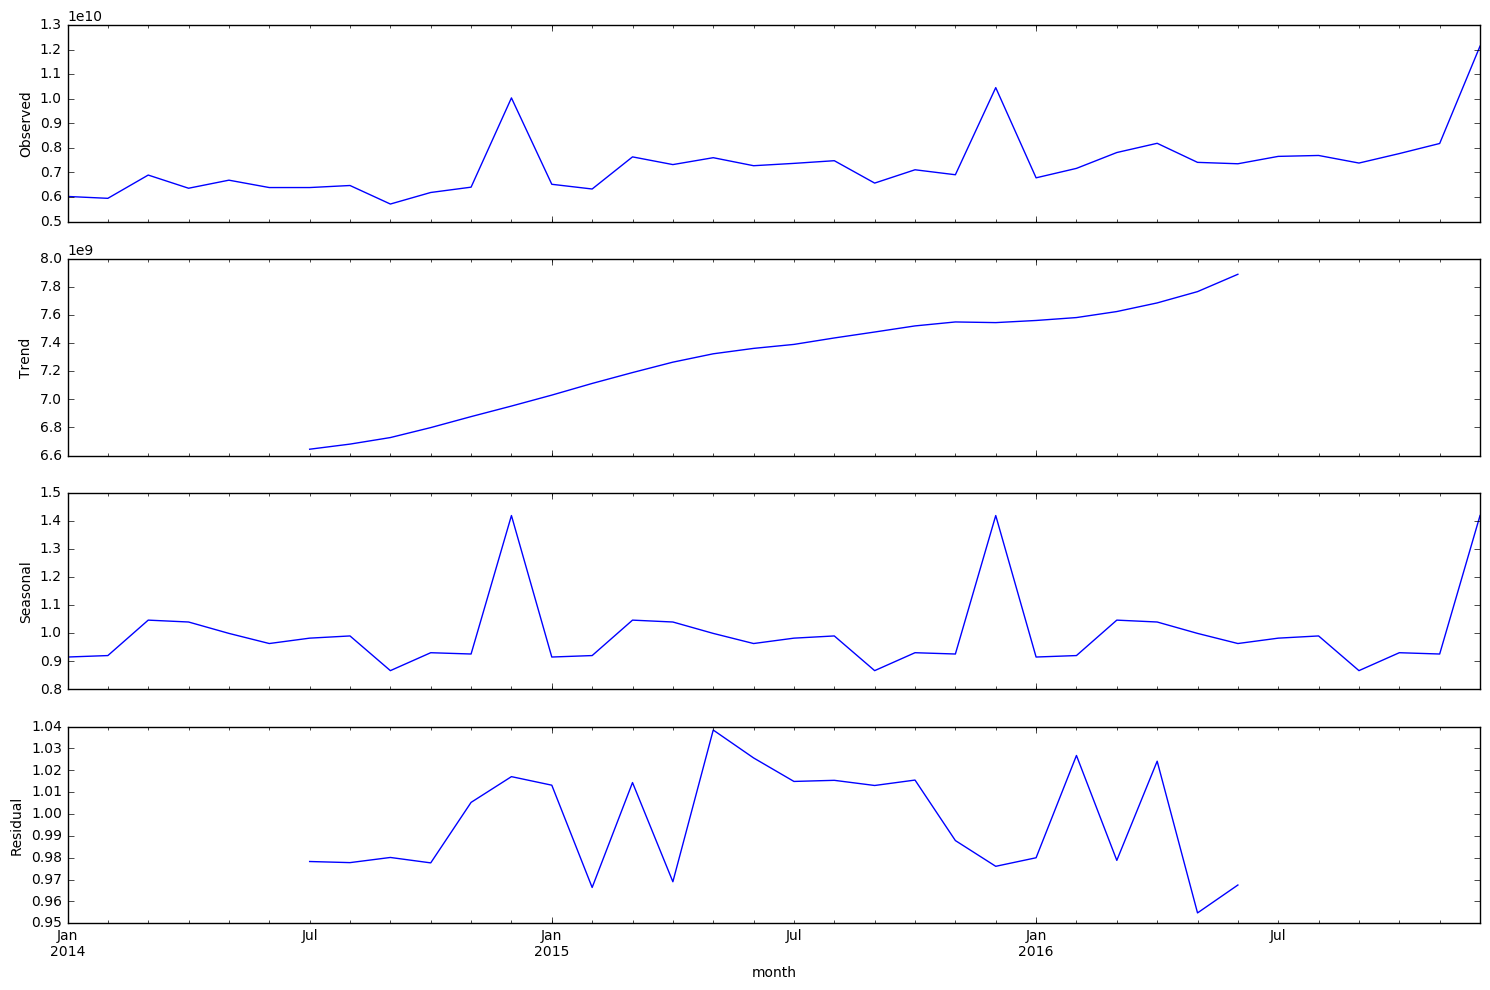

In [122]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.sales,'multiplicative').plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.sales)[1])

In [128]:
pd.concat([sm.tsa.seasonal_decompose(data.sales,'multiplicative').trend,
           sm.tsa.seasonal_decompose(data.sales,'multiplicative').seasonal],axis=1).to_excel(
    os.path.join(path,'trend_season.xlsx'))

In [ ]:
data['sales'], lmbda = stats.boxcox(data.sales)
"Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda

Критерий Дики-Фуллера: p=0.000000


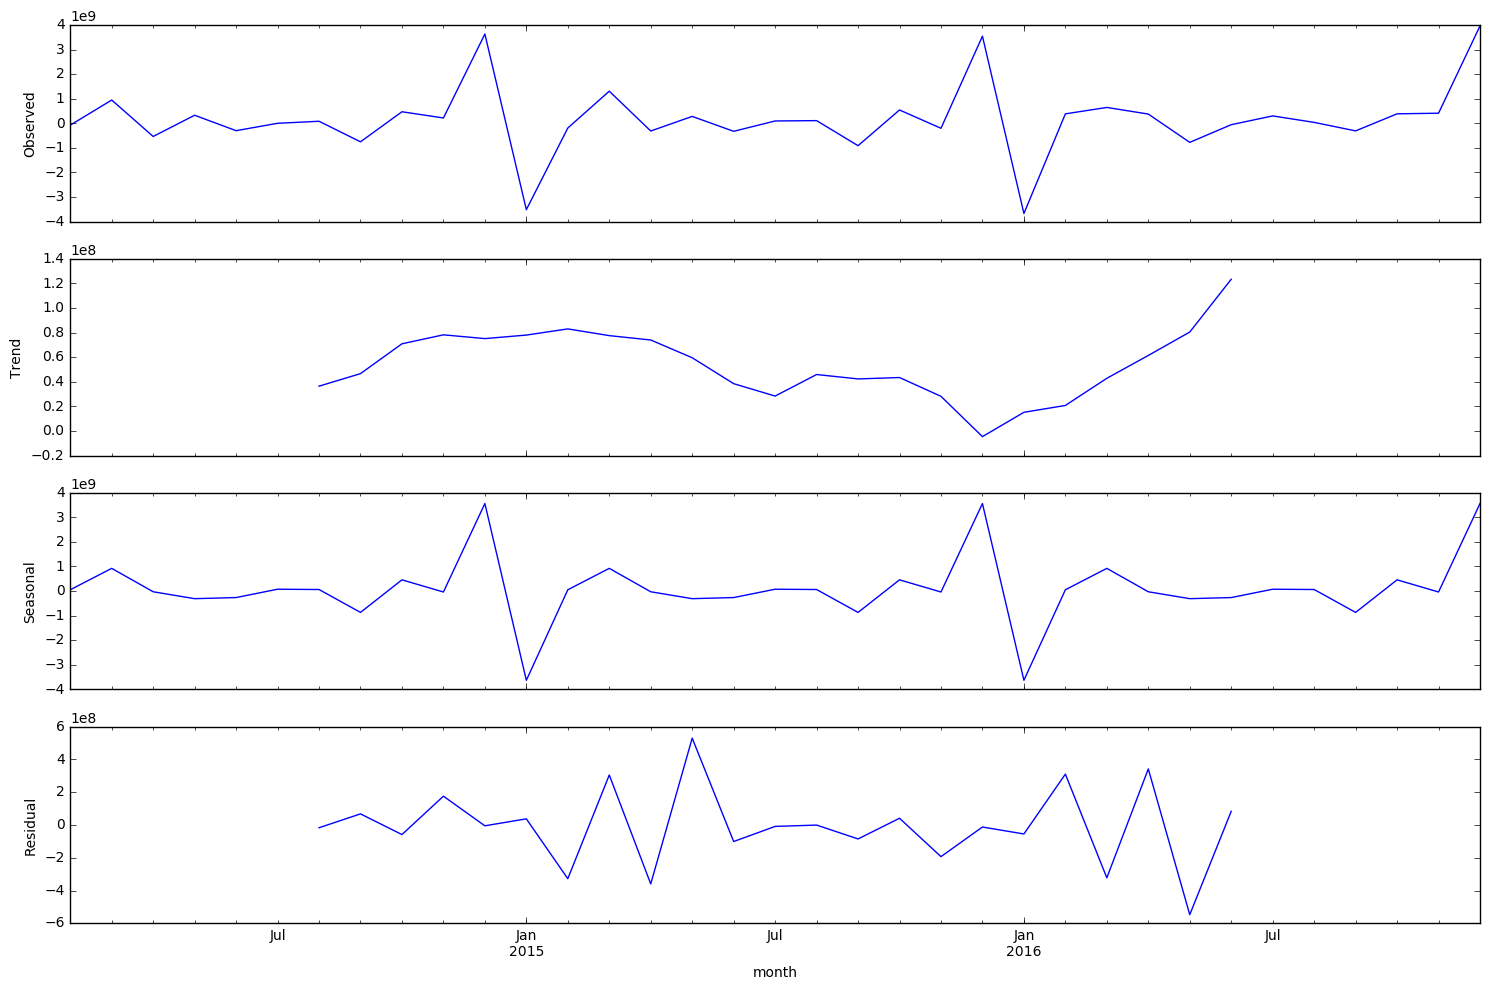

In [104]:
def data_diff(df,column,arr):
    k=1
    df['sales_diff'] = df[column] - df[column].shift(arr[0]) 
    
    for el in arr[1:]:
        df['sales_diff'] = df['sales_diff'] - df['sales_diff'].shift(el)
        k=k+el
    return df,k
        
data,k=data_diff(data,'sales',[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['sales_diff'].dropna())[1])

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.sales_diff.dropna()).plot()
pylab.show()

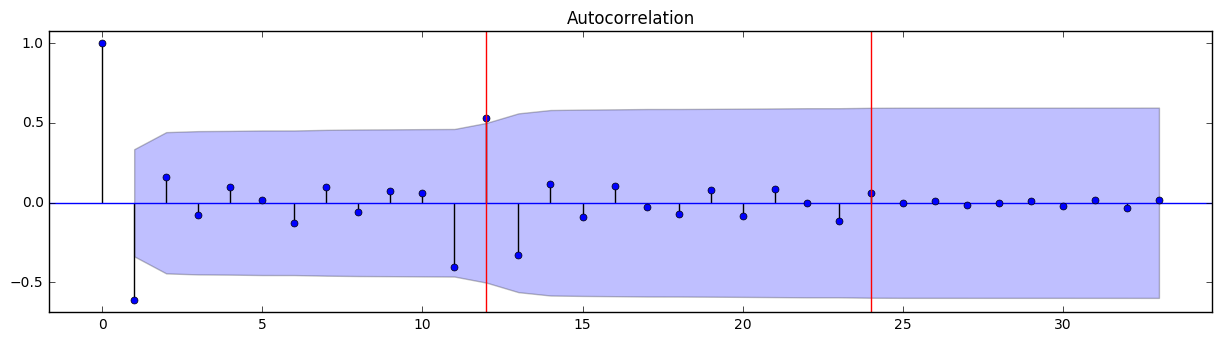

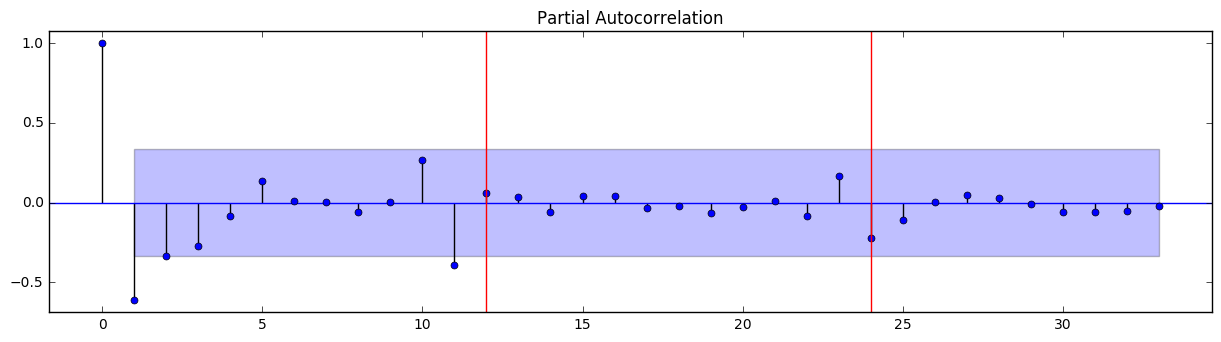

In [25]:
lags=data.shape[0]-k-1
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.sales_diff.dropna().values.squeeze(), lags=lags, ax=ax)
for i in range(12, lags, 12):
    plt.axvline(i, -0.3, 1, c='r')
#x = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(data.sales.dropna().values.squeeze(), lags=12, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.sales_diff.dropna().values.squeeze(), lags=lags, ax=ax)
for i in range(12, lags, 12):
    plt.axvline(i, -0.3, 1, c='r')
pylab.show()

In [109]:
ps = range(0, 11)
d=1 # тк 0 раз дифференциорал
qs = range(0, 11)
Ps = range(0, 3)
D=0 # одно сезонное дифференцирование
Qs = range(0,3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1089

In [ ]:
[method for method in dir(sm.tsa) if callable(getattr(sm.tsa, method))]

In [110]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
column='sales'
for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=SARIMAX(data[column], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic,model])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 2)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 0)
wrong parameters: (0, 0, 2, 1)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 0, 2)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 1, 1, 2)
wrong parameters: (0, 1, 2, 0)
wrong parameters: (0, 1, 2, 1)
wrong parameters: (0, 1, 2, 2)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 0, 2)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 1, 2)
wrong parameters: (0, 2, 2, 0)
wrong parameters: (0, 2, 2, 1)
wrong parameters: (0, 2, 2, 2)
wrong parameters: (0, 3, 0, 0)
wrong parameters: (0, 3, 0, 1)
wrong parameters: (0, 3, 0, 2)
wrong parameters: (0, 3, 1, 0)
wrong parameters: (0, 3, 1, 1)
wrong parameters: (0, 3, 1, 2)
wrong parameters: (0, 3, 2, 0)
wrong parameters: (0, 3, 2, 1)
wrong parameters: (0, 3, 2, 2)
wrong parameters: (0, 4, 0, 1)
wrong pa

LinAlgError: Singular matrix

In [111]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic','model']
result_table=result_table.sort_values(by = 'aic', ascending=True).head().reset_index(drop=True)
result_table

,parameters,aic,model
0,"(0, 1, 0, 0)",1575.889205,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(0, 1, 1, 0)",1576.202747,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(1, 0, 0, 0)",1576.402504,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(1, 0, 1, 0)",1576.604609,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(0, 2, 0, 0)",1577.554996,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [29]:
#Лучшая модель:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                   36
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -768.677
Date:                Mon, 27 Mar 2017   AIC                           1543.355
Time:                        09:30:03   BIC                           1548.105
Sample:                    01-01-2014   HQIC                          1545.013
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1641      0.153     -1.070      0.285      -0.465       0.136
ma.L1         -0.9851      0.207     -4.749      0.000      -1.392      -0.579
sigma2      2.491e+18   7.19e-20   3.46e+37      0.0

C:\Users\ilya.Volchkov\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1457: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

In [ ]:

q_test = sm.tsa.stattools.acf(model.resid.dropna(), qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
#из чего видим что остатки случайны

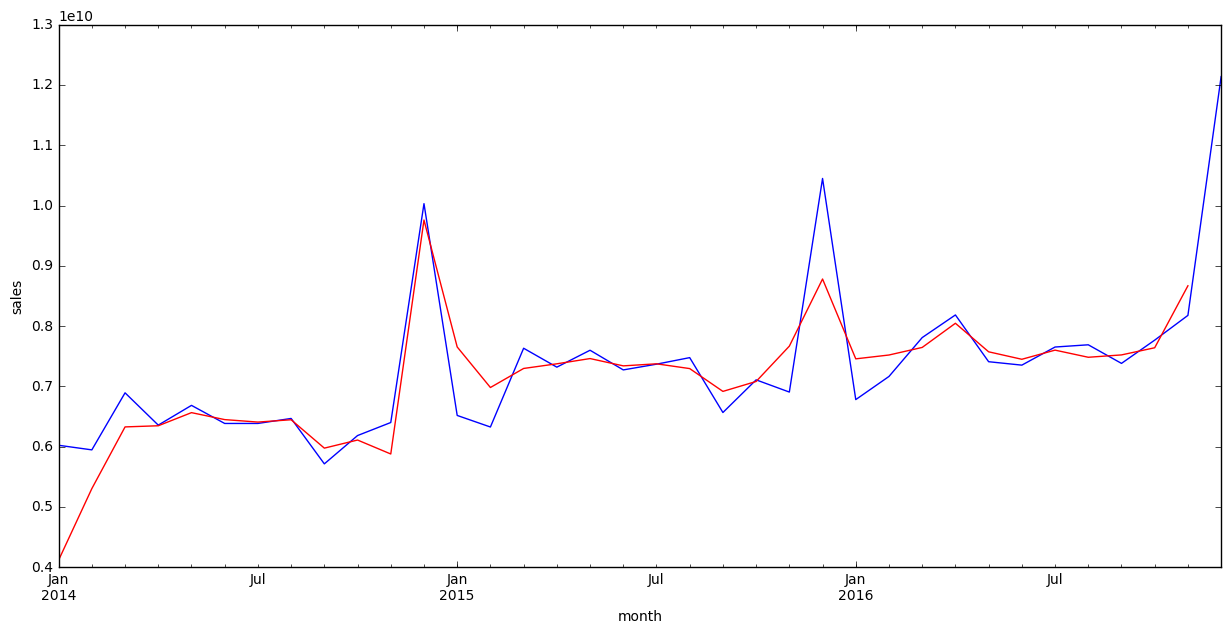

In [113]:
#data['model'] = invboxcox(best_model.fittedvalues, lmbda)
data['model'] = result_table['model'][1].fittedvalues.shift(-1)
plt.figure(figsize(15,7))
data.sales.plot()
data.model.dropna().plot(color='r')
plt.ylabel('sales')
pylab.show()

In [119]:
data2 = fulldata
date_list = [max(data2.index) + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = best_model.predict(start=data.shape[0], end=data2.shape[0]).shift(-1)

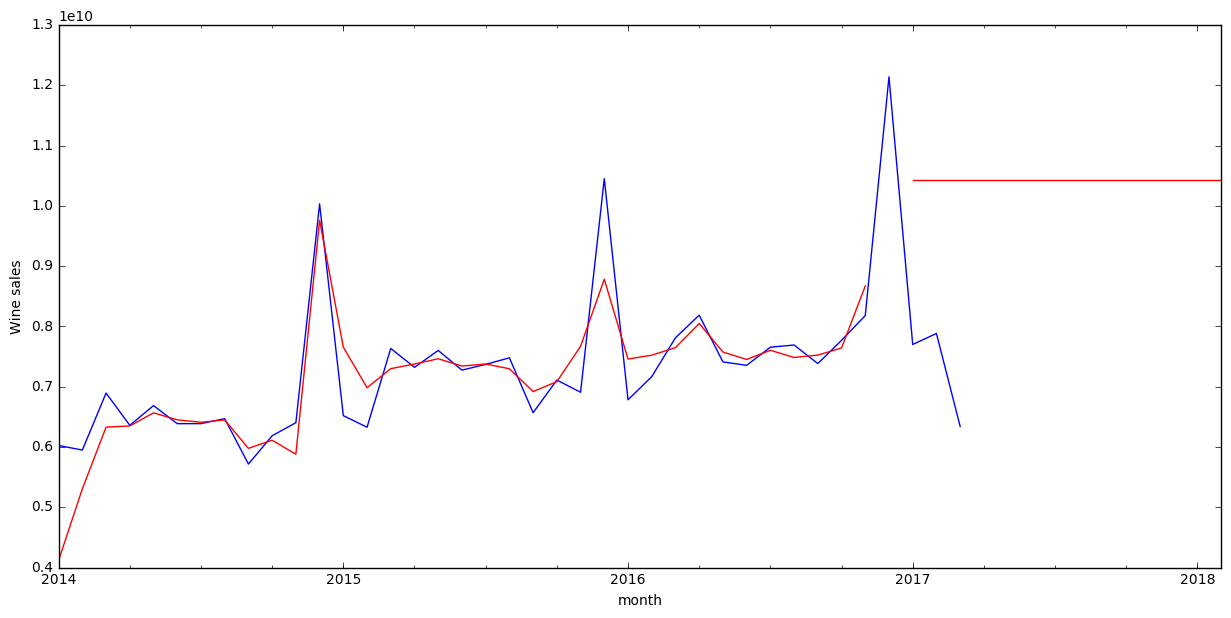

In [120]:
plt.figure(figsize(15,7))
data2.sales.dropna().plot()
data2.forecast.dropna().plot(color='r')
data.model.dropna().plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

# Regression forecast

In [360]:
data = pd.read_csv(os.path.join(path,'total_sales_day.csv'),';', index_col=['day'], parse_dates=['day'], dayfirst=True)
data=data.ix[:,:3]

In [361]:
%%time
min_date=min(data.index)
data['day_of_week']=data.index.dayofweek
data['month']=data.index.month
data['total_days']=(data.index-min_date).days
data['num_day']=data.index.day
data['month_part']=data.num_day.apply(lambda x:x//8 )
data['week_num']=data.index.week

moving_week_window=3
moving_month_window=3

for i in range(1,moving_week_window+3):
    data[str(i)+'_week_before']=data.index-timedelta(days=7*i)
data['date_withot_day']=[data.index[i]-timedelta(days=int(data.num_day.values[i]-1))  for i in range(data.shape[0])]
for i in range(1,moving_month_window+3):
    data[str(i)+'_month_before']=data['date_withot_day'].apply(lambda x:x-relativedelta(months=+1*i))

Wall time: 42.2 s


In [362]:
data.tail(3)

,filial,store,sales,day_of_week,month,total_days,num_day,month_part,week_num,1_week_before,2_week_before,3_week_before,4_week_before,5_week_before,date_withot_day,1_month_before,2_month_before,3_month_before,4_month_before,5_month_before
day,,,,,,,,,,,,,,,,,,,,
2017-03-24,Филиал Южный,1162,2156235.37,4,3,1178,24,3,12,2017-03-17,2017-03-10,2017-03-03,2017-02-24,2017-02-17,2017-03-01,2017-02-01,2017-01-01,2016-12-01,2016-11-01,2016-10-01
2017-03-25,Филиал Южный,1162,2344565.01,5,3,1179,25,3,12,2017-03-18,2017-03-11,2017-03-04,2017-02-25,2017-02-18,2017-03-01,2017-02-01,2017-01-01,2016-12-01,2016-11-01,2016-10-01
2017-03-26,Филиал Южный,1162,2035948.87,6,3,1180,26,3,12,2017-03-19,2017-03-12,2017-03-05,2017-02-26,2017-02-19,2017-03-01,2017-02-01,2017-01-01,2016-12-01,2016-11-01,2016-10-01


In [363]:
%%time
def find_in_agg_df(df,pattern):
    try:r=df.ix[tuple(pattern)]['sales']
    except:r=np.nan
    return r

agg_month=data[['date_withot_day','sales','store']].pivot_table(index=['date_withot_day','store'],aggfunc=np.sum)
for i in range(1,moving_month_window+3):
    column_name=str(i)+'_month_before'
    data[column_name]=data[[column_name,'store']].apply(lambda row:find_in_agg_df(agg_month,row),axis=1)

Wall time: 5min 4s


In [364]:
%%time
def create_moving_week(df):
    df.reset_index(inplace=True)
    start_date=min_date+timedelta(days=6)
    res=df[df['day']>start_date][['day','store','1_week_before']].reset_index(drop=True)

    
    res['sales']=res.apply(lambda row:np.sum(df[(df['store']==row['store'])&
                                         (df['day']>=row['1_week_before'])&
                                         (df['day']<row['day'])]['sales']),axis=1)
    
    res.drop('1_week_before',axis=1,inplace=True)
    res.set_index(['day', 'store'],inplace=True)
    return res
agg_week_df=create_moving_week(data)

Wall time: 7min 6s


In [365]:
%%time
for i in range(1,moving_week_window+3):
    column_name=str(i)+'_week_before'
    data[column_name]=data[[column_name,'store']].apply(lambda row:find_in_agg_df(agg_week_df,row),axis=1)

Wall time: 5min 26s


In [366]:
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)

In [367]:
for i in range(1,moving_week_window+1):
    
    column_names=[str(x)+'_week_before' for x in range(i,i+3) ]
    column_name_new=str(i)+'avg_week'
    data[column_name_new]=data[column_names].apply(np.mean,axis=1)

In [368]:
for i in range(1,moving_month_window+1):
    column_names=[str(x)+'_month_before' for x in range(i,i+3) ]
    column_name_new=str(i)+'avg_month'
    data[column_name_new]=data[column_names].apply(np.mean,axis=1)

In [369]:
columns=[str(x)+'_week_before' for x in range(1,moving_week_window+3)]+[
    str(x)+'_month_before' for x in range(1,moving_month_window+3)]
data.drop(columns,axis=1,inplace=True)

,day,filial,store,sales,day_of_week,month,total_days,num_day,month_part,week_num,date_withot_day,1avg_week,2avg_week,3avg_week,1avg_month,2avg_month,3avg_month
0,2014-06-01,Филиал Волго-Вятский,1007,2099868.07,6,6,151,1,0,22,2014-06-01,1.554657e+07,1.578622e+07,1.534808e+07,6.837368e+07,6.687008e+07,6.540813e+07
1,2014-06-02,Филиал Волго-Вятский,1007,1914364.85,0,6,152,2,0,23,2014-06-01,1.555499e+07,1.571742e+07,1.545313e+07,6.837368e+07,6.687008e+07,6.540813e+07
2,2014-06-03,Филиал Волго-Вятский,1007,1911960.77,1,6,153,3,0,23,2014-06-01,1.557440e+07,1.570993e+07,1.565888e+07,6.837368e+07,6.687008e+07,6.540813e+07
3,2014-06-04,Филиал Волго-Вятский,1007,1941583.36,2,6,154,4,0,23,2014-06-01,1.556517e+07,1.562534e+07,1.578463e+07,6.837368e+07,6.687008e+07,6.540813e+07
4,2014-06-05,Филиал Волго-Вятский,1007,2109406.06,3,6,155,5,0,23,2014-06-01,1.544459e+07,1.519483e+07,1.583396e+07,6.837368e+07,6.687008e+07,6.540813e+07
5,2014-06-06,Филиал Волго-Вятский,1007,2685200.02,4,6,156,6,0,23,2014-06-01,1.517428e+07,1.509492e+07,1.581212e+07,6.837368e+07,6.687008e+07,6.540813e+07
6,2014-06-07,Филиал Волго-Вятский,1007,2505603.14,5,6,157,7,0,23,2014-06-01,1.521499e+07,1.539695e+07,1.580994e+07,6.837368e+07,6.687008e+07,6.540813e+07
7,2014-06-08,Филиал Волго-Вятский,1007,2078175.76,6,6,158,8,1,23,2014-06-01,1.534244e+07,1.554657e+07,1.578622e+07,6.837368e+07,6.687008e+07,6.540813e+07
8,2014-06-09,Филиал Волго-Вятский,1007,1987739.46,0,6,159,9,1,24,2014-06-01,1.533800e+07,1.555499e+07,1.571742e+07,6.837368e+07,6.687008e+07,6.540813e+07
9,2014-06-10,Филиал Волго-Вятский,1007,2224809.89,1,6,160,10,1,24,2014-06-01,1.530059e+07,1.557440e+07,1.570993e+07,6.837368e+07,6.687008e+07,6.540813e+07


In [374]:
data.columns

Index(['day', 'filial', 'store', 'sales', 'day_of_week', 'month', 'total_days',
       'num_day', 'month_part', 'week_num', 'date_withot_day', '1avg_week',
       '2avg_week', '3avg_week', '1avg_month', '2avg_month', '3avg_month'],
      dtype='object')

In [375]:
real_features=['sales','total_days','1avg_week','2avg_week', '3avg_week','1avg_month', '2avg_month', '3avg_month']
cat_features=['filial','store','day_of_week', 'month', 'month_part','week_num']

In [380]:
def transform(df,real_columns,cat_columns):
    df.is_a_copy=False

    df_real=df[real_columns]
    scaler = StandardScaler()
    df_real=pd.DataFrame(scaler.fit_transform(df_real),columns=real_columns)
    res=[df_real]
    df_cat=df[cat_columns]
    for column in df_cat.columns.values:
        data_slice=df_cat[column].astype(str)
        res.append(pd.get_dummies(data_slice,prefix =column, dummy_na=False))        
    res=pd.concat(res,axis=1)
    return res

transform(data,real_features,cat_features)

,sales,total_days,1avg_week,2avg_week,3avg_week,1avg_month,2avg_month,3avg_month,filial_Филиал Волго-Вятский,filial_Филиал Приволжский,...,week_num_49,week_num_5,week_num_50,week_num_51,week_num_52,week_num_53,week_num_6,week_num_7,week_num_8,week_num_9
0,-0.476753,-1.750395,-0.462354,-0.436842,-0.476906,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.586058,-1.747052,-0.461536,-0.443524,-0.466688,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.587475,-1.743710,-0.459653,-0.444252,-0.446675,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.570020,-1.740367,-0.460549,-0.452469,-0.434443,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.471132,-1.737025,-0.472248,-0.494285,-0.429646,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.131851,-1.733682,-0.498474,-0.503989,-0.431769,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
6,-0.237677,-1.730340,-0.494525,-0.474653,-0.431982,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
7,-0.489535,-1.726997,-0.482159,-0.460120,-0.434289,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
8,-0.542823,-1.723655,-0.482589,-0.459302,-0.440981,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0
9,-0.403132,-1.720312,-0.486220,-0.457416,-0.441709,-0.448309,-0.468976,-0.489698,1,0,...,0,0,0,0,0,0,0,0,0,0


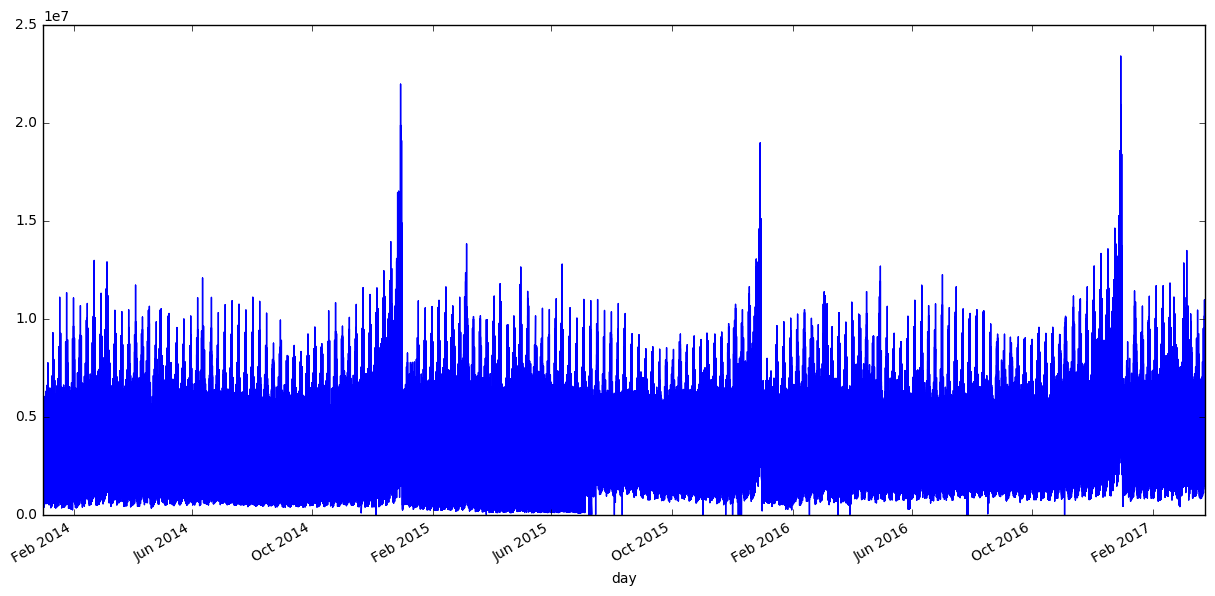

In [141]:
plt.figure(figsize(15,7))
data.sales.plot()
#plt.ylabel(u'')
#plt.title('')
pylab.show()